# Introduction

The last two years have caused a huge increase in cashless transactions. Many banks are commending their internet banking and mobile banking applications because not only they can save customers time but also they can help in coping with Coronavirus spread. I did the sentiment analysis of the users reviews of 10 different Android and iOS mobile banking applications from 10 different banks in Rwanda left on both Google Play Store and Apple Store before 2020 and after 2020 to see whether customers are leaving Negative or Positive reviews. The process involved getting reviews using the applications' IDs on Google Play and Apple Store respectively, processing the reviews (tokenization, correcting contractions and correcting spelling, lemmatization and removing non alphabetical characters, ...), checking the sentiment of the reviews using a combination of Textblob and Vader (the former uses the polarity and the subjectivity of the text while the later uses the emotion intensities associated with each lexical feature) and visualizing the results. 

# Data Acquisation

In [1]:
# Important libraries
import pandas as pd
pd.options.display.max_colwidth = None
from data_reader import get_google_reviews, get_apple_reviews
from data_processor import monthly_average_score, process_sentence, find_sentiment_score
import warnings
warnings.filterwarnings('ignore')
from graph_utils import plot_line, plot_sentiments_ratings, distribution_fig, summary_figures
from PIL import Image
from tqdm import tqdm
tqdm.pandas(desc="Completed ")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gnzasabimfura\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gnzasabimfura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gnzasabimfura\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gnzasabimfura\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#Applications' IDs
google_playstore = {'equity' : 'ke.co.equitybank.equitel',
                   'gtbank': 'com.vanso.gtbankapp',
                   'ecobank' : 'com.app.ecobank',
                   'access': 'com.accessbank.accessbankapp',
                   'kcb': 'com.kcbbankgroup.android',
                    'bk' : 'com.pivotaccess.bkmobile', 
                    'i_m' : 'com.inm.rwret',
                    'zigama' : 'com.zigamacss.banking',
                    'cogebanque' : 'rw.co.cogebanque.client',
                    'bpr' : 'com.mfs.bpratlasmara.ui'}

apple_store = {'bk': '1241904638', 'cogebanque': '1298101863', 'zigama': '1380204686',
               'bpr': '1476541810', 'i_m':'1439313553', 'equity':'1139202853',
              'gtbank': '573523974', 'ecobank': '1017658759', 'access' : '730325311',
              'kcb': '974226567'}

In [4]:
#Google
android = get_google_reviews(google_playstore)
# android.to_csv('Google Play Store.csv', index = False)
#Apple
ios = get_apple_reviews(apple_store)
# ios.to_csv('Apple Store.csv', index = False)

Retrieving kcb: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.78s/it]


In [5]:
print(android.columns)
print(ios.columns)

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'bank'],
      dtype='object')
Index(['author.uri.label', 'author.name.label', 'author.label',
       'updated.label', 'im:rating.label', 'im:version.label', 'id.label',
       'title.label', 'content.label', 'content.attributes.type',
       'link.attributes.rel', 'link.attributes.href', 'im:voteSum.label',
       'im:contentType.attributes.term', 'im:contentType.attributes.label',
       'im:voteCount.label', 'bank'],
      dtype='object')


In [6]:
#Selecting target columns - Android
android_reviews = android[['at', 'score', 'content']]
android_reviews.columns = ['Datetime', 'Rate', 'Review']
android_reviews.head(3)

,Datetime,Rate,Review
0,2021-11-29 17:22:36,4,So far the features I have been using work very well.
1,2021-11-06 22:21:14,5,Better & simple app
2,2021-10-21 15:13:41,3,"This app makes life easier, you can pay or transfer money easily. However i don't like the fact that it has to access your location 😏"


In [7]:
#Selecting target columns - iOS
ios_reviews = ios[['updated.label', 'im:rating.label', 'content.label']]
ios_reviews.columns = ['Datetime', 'Rate', 'Review']
ios_reviews.head(3)

,Datetime,Rate,Review
0,2021-01-09T17:56:17-07:00,5,This app works pretty fine !!\nBut one thing is missing \nSince its an app bank it needs more security. i wish they could add like get app locked with either passcode/face id /touch id it would be more secure
1,2020-05-21T14:13:47-07:00,4,Usually works perfectly; rare connections issues
2,2019-03-15T08:16:43-07:00,4,I just downloaded the app and i my self im one of the people who have an account in the bank so is it necessary to go the bank for the ligin or id information??


In [8]:
#Joining both reviews and harmonizing the Datetime columns
reviews = pd.concat([android_reviews, ios_reviews])
reviews['Datetime'] = pd.to_datetime(reviews['Datetime'])
#reviews.to_csv('Reviews.csv', index = False)
reviews['Datetime'].min()

Timestamp('2012-11-14 11:12:27-0700', tz='pytz.FixedOffset(-420)')

# Ratings Over Time

Even though the first review date back in late 2012 most of the applications got their first reviews in 2016 or later. I decided to consider only reviews from January 1, 2017 to November 30, 2021. This analysis only shows the ratings given followed by a review note.

In [9]:
# reviews = pd.read_csv('Reviews.csv')
# reviews['Datetime'] = pd.to_datetime(reviews['Datetime'])
reviews = reviews[(reviews['Datetime'] >= "2017-01-01") & (reviews['Datetime'] <= "2021-11-30")]
mean_monthly_rate = monthly_average_score(reviews, 'M')
mean_monthly_rate['Rate'] = mean_monthly_rate['Rate'].apply(lambda x: round(x,1))
mean_monthly_rate.head()

,Rate
Datetime,
2017-01-31 00:00:00-07:00,3.7
2017-02-28 00:00:00-07:00,3.9
2017-03-31 00:00:00-07:00,3.8
2017-04-30 00:00:00-07:00,4.1
2017-05-31 00:00:00-07:00,4.2


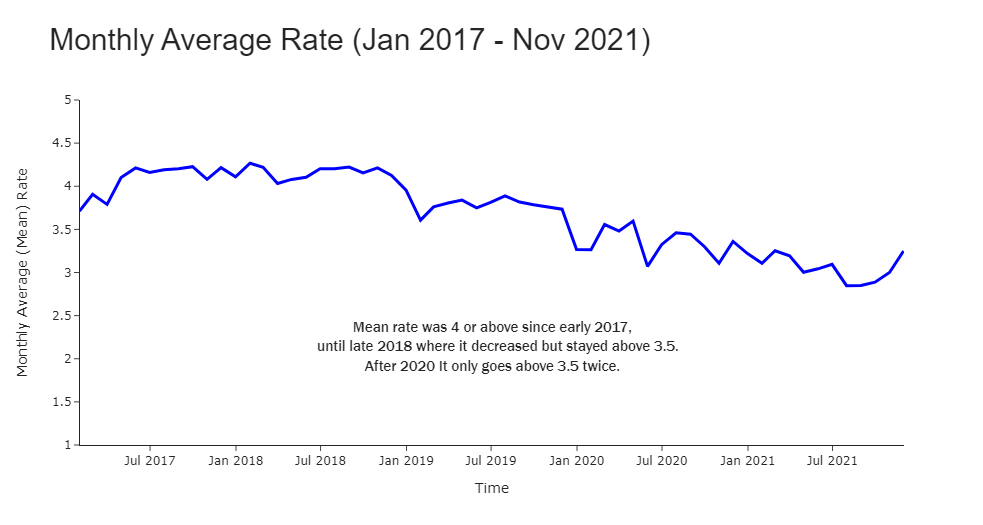

In [10]:
plot_line(mean_monthly_rate)
#Image.open('monthly_average_rate.png')

# SENTIMENT ANALYSIS

There are several methods to obtain whether a comment/review is positive, neutral or negative. In python two of some popular libraries that help help in sentiment analysis are [**Textblob**](https://textblob.readthedocs.io/en/dev/) and [**Vader**](https://github.com/cjhutto/vaderSentiment). The former uses the polarity and the subjectivity of the text while the later uses the emotion intensities associated with each lexical feature. Textblob is generalized while Vader is attuned to social media sentiments and can work with [**NLTK**](https://github.com/cjhutto/vaderSentiment) to provide sentiments on longer & tricky sentences that confuse other sentiment analysis tools.

## Pre-processing

The reviews are first pre-processed by expanding contractions, tokenisation, correcting spellings, lemmatizations (reducing words to their roots) and removing non-alphabetical characters.

In [11]:
reviews['clean'] = reviews['Review'].progress_apply(process_sentence)
#reviews.to_csv('cleaned_reviews.csv', index = False)

Completed : 100%|██████████████████████████████████████████████████████████████| 70525/70525 [3:34:50<00:00,  5.47it/s]


## Checking the review's sentiment

The sentiment is obtained by leveraging both Textblob and Vader scores.

In [12]:
reviews['Sentiment'] = reviews['clean'].progress_apply(find_sentiment_score)
#reviews.to_csv('sentiments_reviews.csv', index = False)
#reviews = pd.read_csv('sentiments_reviews.csv')

Completed : 100%|███████████████████████████████████████████████████████████████| 70525/70525 [07:46<00:00, 151.22it/s]


## Overall Sentiments

### Samples

In [13]:
positive_sample = reviews[reviews['Sentiment'] == 'Positive'].sample(10)
negative_sample = reviews[reviews['Sentiment'] == 'Negative'].sample(10)

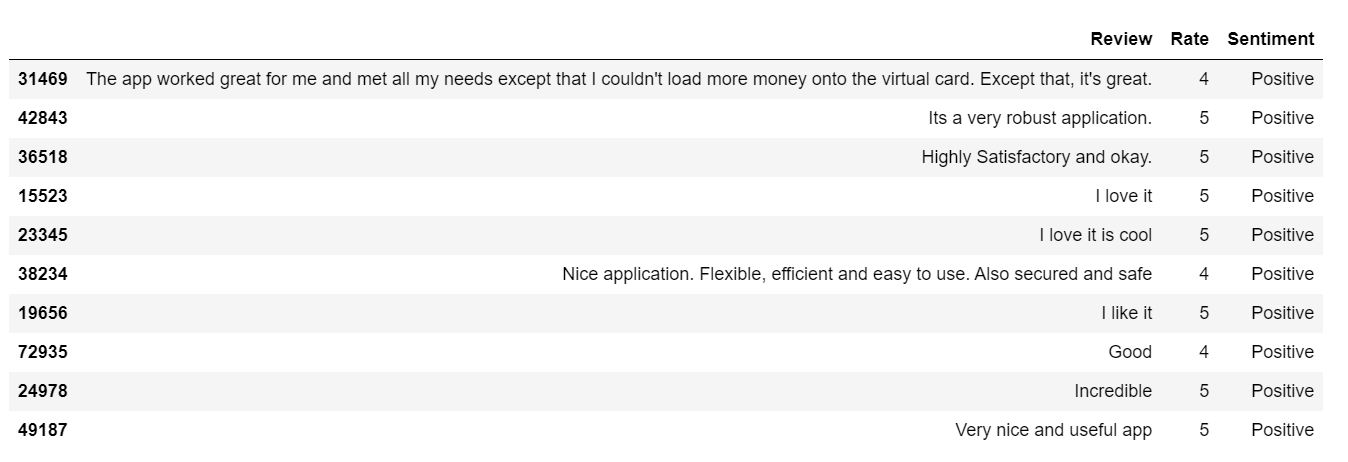

In [14]:
positive_sample[['Review','Rate','Sentiment']]
# Image.open('positive_sample.png')

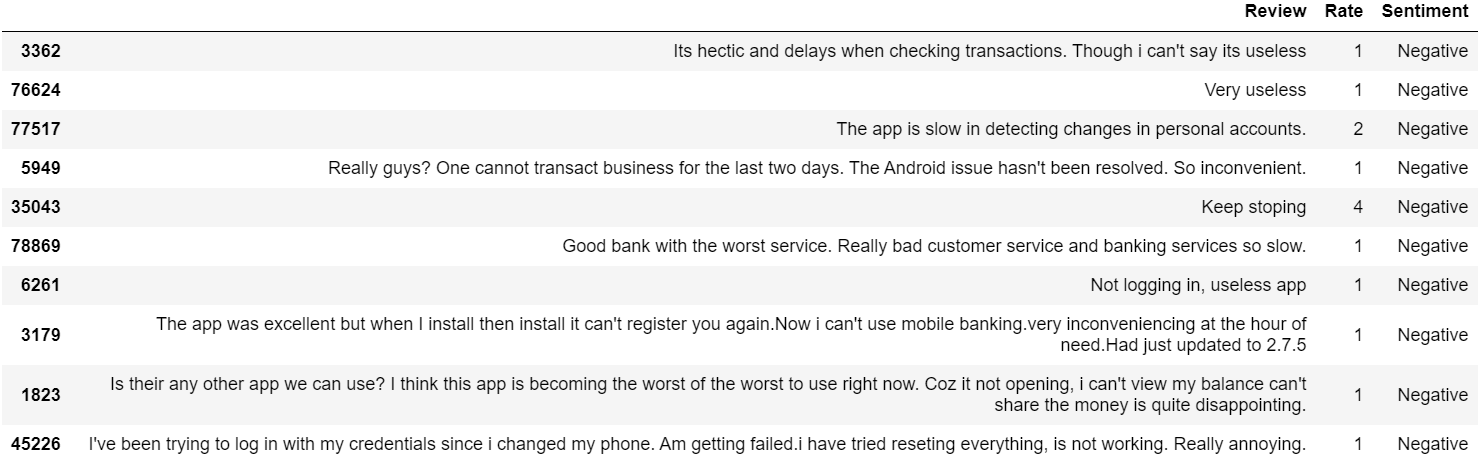

In [15]:
reviews[reviews['Sentiment'] == 'Negative'].sample(10)[['Review','Rate','Sentiment']]
# Image.open('negative_sample.png')

### Distribution

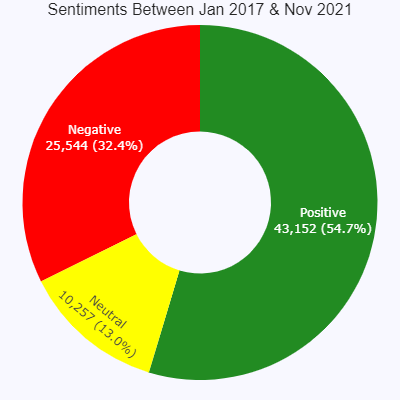

In [16]:
distribution_fig(reviews, title = "Sentiments Between Jan 2017 & Nov 2021")
# Image.open('overall_sentiments.png')

> Overall, slightly more than a half of reviews are positive while 13% are classfied as Neutral.

## Sentiments by rating

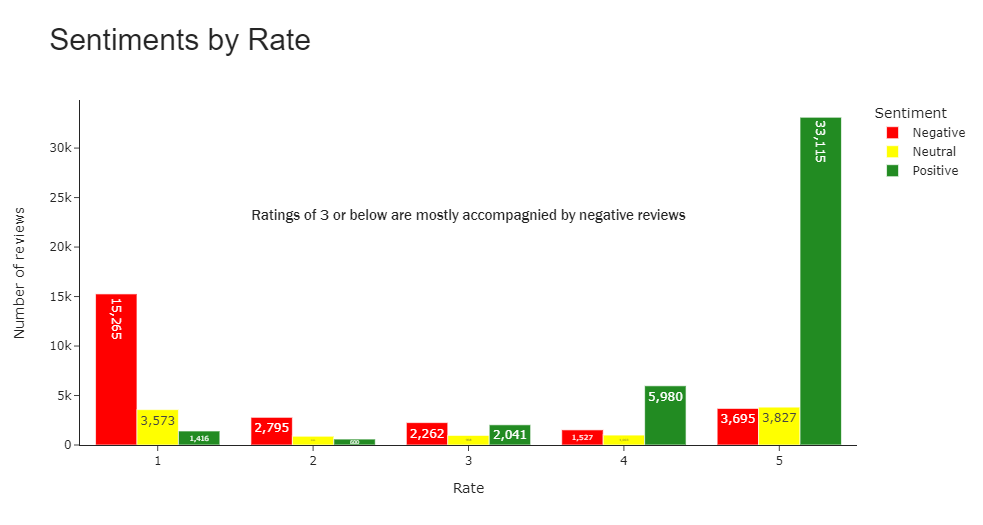

In [17]:
sentiment_by_rating = reviews[['Rate','Sentiment']].groupby(['Rate', 'Sentiment'], as_index = False).size()
plot_sentiments_ratings(sentiment_by_rating)
# Image.open('sentiments_by_rate.png')

> Ratings of 3 or below are mostly dominated with negative reviews

## Sentiment Before 2020

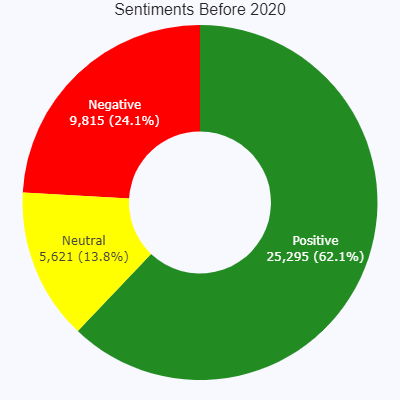

In [18]:
reviews_before = reviews[reviews['Datetime'] < "2020-01-01"]
distribution_fig(reviews_before, "Sentiments Before 2020")
# Image.open('sentiments_before.png')

> Before 2020, 62% of reviews were positive and only 24% were negative.

## Sentiment After 2020

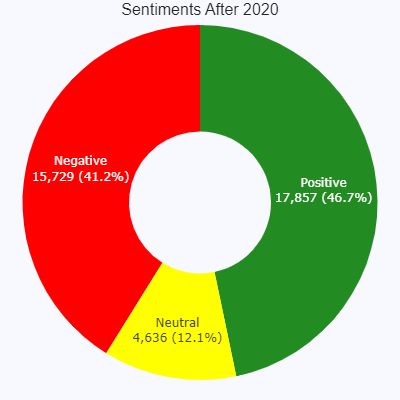

In [20]:
reviews_after = reviews[reviews['Datetime'] > "2020-01-01"]
distribution_fig(reviews_after, title = "Sentiments After 2020")
# Image.open('sentiments_after.png')

> After 2020, positive reviews goes down to 46% while negative reviews increased to 41%.

# Conclusion & Future Work

Negative reviews increased from 24% before 2020 to 41% after 2020. Most negative reviews are associated with the rate of 3 or below.

The next step would be to check the upvotes of different sentiment, looking at reply/feedback rate to see whether the developers acknowledged negative feedbacks or provided help, and trying to classify/cluster the sentiment by topics. For example to see whether negative sentiments are associated with devices/os incompatibility, or some applications' features.

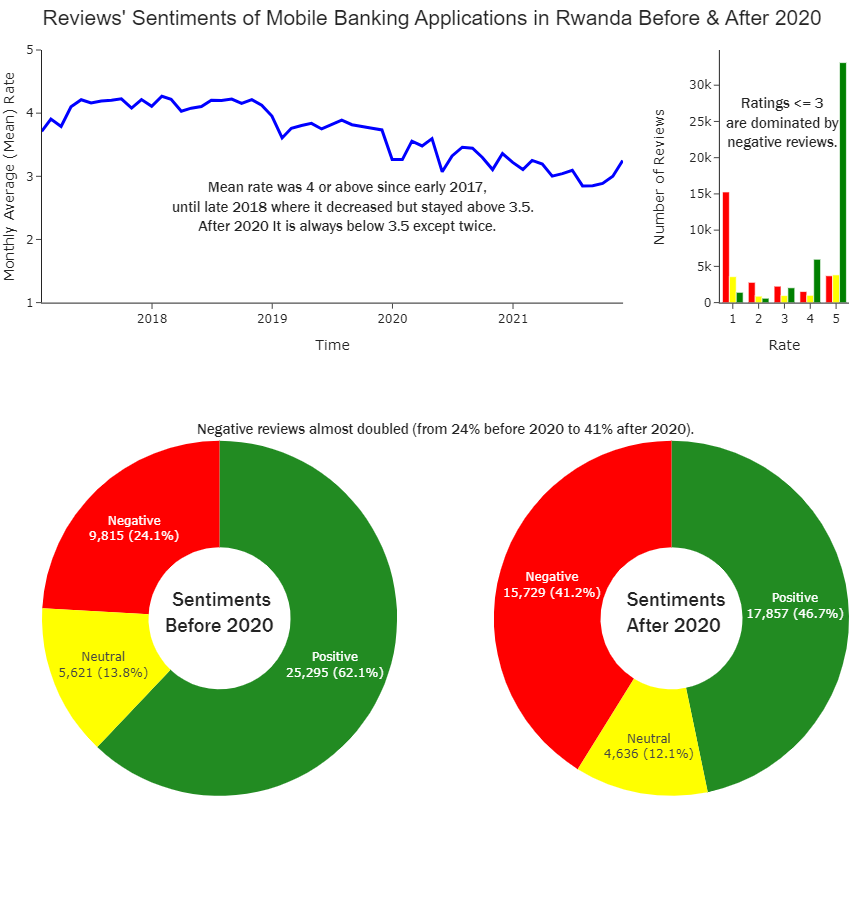

In [21]:
summary_figures(mean_monthly_rate, sentiment_by_rating, reviews_before, reviews_after)
# Image.open('summary.png')

# References

https://github.com/JoMingyu/google-play-scraper

http://blog.manbolo.com/2012/09/10/useful-itunes-web-services


---
https://www.nltk.org/howto/sentiment.html

https://textblob.readthedocs.io/en/dev/